# Age, Gender and Race Estimation

Based on UTKFace dataset

### Setup

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import keras

from keras.layers import Convolution2D, Flatten, Dense, MaxPool2D, Input, Dropout

from keras.models import Sequential
from keras.utils import plot_model


devices =  tf.config.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device, True)
tf.config.set_soft_device_placement(True)

img_folder = "UTKFace/"

### Importing Dataset

The labels of each face image is embedded in the file name, formated like `[age]_[gender]_[race]_[date&time].jpg`

- `[age]` is an integer from 0 to 116, indicating the age
- `[gender]` is either 0 (male) or 1 (female)
- `[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- `[date&time]` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [3]:
from os import listdir

image_list = []
age_list = []
gender_list = []
race_list = []


for file in listdir(img_folder):
    splited_file = file.split("_")
    age = splited_file[0]
    gender = splited_file[1]
    race = splited_file[2]
    image = img_folder + file
     
    age_list.append(age)
    gender_list.append(gender)
    race_list.append(race)
    image_list.append(image)

In [4]:
image_series = pd.Series(image_list, name="Image")
gender_series = pd.Series(gender_list, name="Gender")
race_series = pd.Series(race_list, name="Race")
age_series = pd.Series(age_list, name="Age")

df = pd.concat([image_series, age_series, gender_series, race_series], axis="columns")
df["Age"] = df["Age"].astype(int)
df.to_csv("images_data.csv")

### Exploring Data

#### Age

In [5]:
df.sort_values(by="Age")

,Image,Age,Gender,Race
2226,UTKFace/1_1_0_20161219205534526.jpg.chip.jpg,1,1,0
2047,UTKFace/1_0_3_20161219225723376.jpg.chip.jpg,1,0,3
2048,UTKFace/1_0_3_20161219225759904.jpg.chip.jpg,1,0,3
2049,UTKFace/1_0_3_20161219225808112.jpg.chip.jpg,1,0,3
2050,UTKFace/1_0_3_20161219225811120.jpg.chip.jpg,1,0,3
...,...,...,...,...
183,UTKFace/115_1_1_20170112213257263.jpg.chip.jpg,115,1,1
184,UTKFace/116_1_0_20170112213001988.jpg.chip.jpg,116,1,0
185,UTKFace/116_1_0_20170120134921760.jpg.chip.jpg,116,1,0
186,UTKFace/116_1_2_20170112220255503.jpg.chip.jpg,116,1,2


<Axes: xlabel='Age', ylabel='Count'>

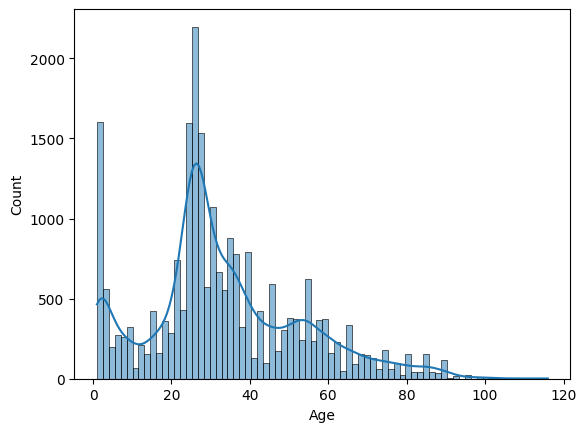

In [6]:
sns.histplot(data=df, x="Age", kde=True)

As we can see, there is a lot of image of childs between 0 and 5 years old, and it can provide to overfitting. Also, we can notice, that there are few examples of people with age below 85 years, so it might be good decision to delete this examples from dataset.

<Axes: xlabel='Age', ylabel='Count'>

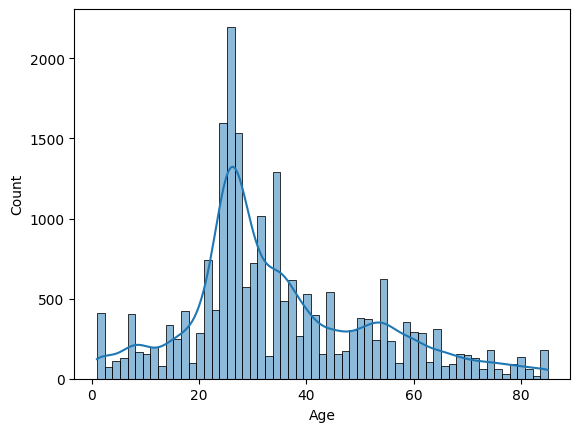

In [7]:
ageunder5 = df.loc[df["Age"] <= 5]
agebelow85 = df.loc[df["Age"] > 85]
ageunder5.sample(frac=0.25)
df_normalized = pd.concat([df.drop(ageunder5.index).drop(agebelow85.index), ageunder5.sample(frac=0.25)])
sns.histplot(df_normalized["Age"], kde=True)

Looks better! Now we can see, that age distribution is close to normal and we have definetly solved overfiting problem.

#### Gender

In [8]:
df.head()

,Image,Age,Gender,Race
0,UTKFace/100_0_0_20170112213500903.jpg.chip.jpg,100,0,0
1,UTKFace/100_0_0_20170112215240346.jpg.chip.jpg,100,0,0
2,UTKFace/100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
3,UTKFace/100_1_0_20170112213001988.jpg.chip.jpg,100,1,0
4,UTKFace/100_1_0_20170112213303693.jpg.chip.jpg,100,1,0


<Axes: xlabel='Gender', ylabel='count'>

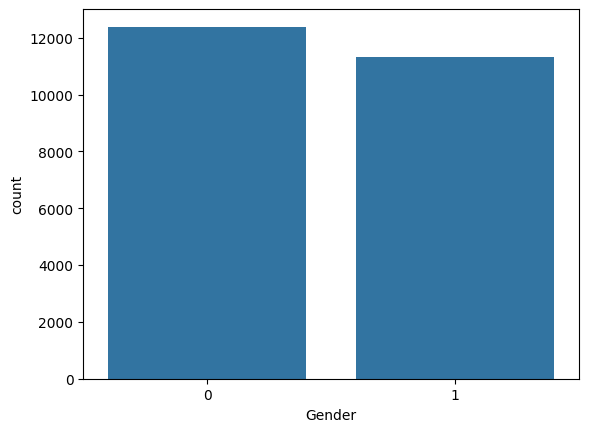

In [9]:
sns.countplot(data=df, x="Gender")

As we can notice, distribution of genders in this dataset is close to be equal, so we dont need to preprocess it.

#### Race

<Axes: xlabel='Race', ylabel='count'>

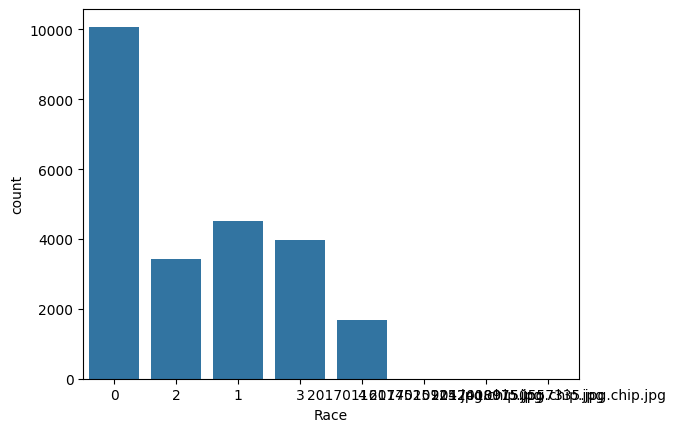

In [10]:
sns.countplot(data=df, x="Race")

As we can notice from that plot, some of file might note have correct names, so it produced 3 new races. Lets find this files and take a look on them.


In [11]:
df["Race"].unique()

array(['0', '2', '1', '3', '4', '20170116174525125.jpg.chip.jpg',
       '20170109142408075.jpg.chip.jpg', '20170109150557335.jpg.chip.jpg'],
      dtype=object)

In [12]:
suspecious_files = []

for file in listdir(img_folder):
    if str(file).find("20170116174525125.jpg.chip.jpg") != -1:
        print(file)
        suspecious_files.append(file)
    if str(file).find("20170109142408075.jpg.chip.jpg") != -1:
        print(file)
        suspecious_files.append(file)
    if str(file).find("20170109150557335.jpg.chip.jpg") != -1:
        print(file)
        suspecious_files.append(file)
        

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg


We just found out that there are few files with incorrect filenames! It means, that we can't be 100% sure of what is the race of the person on image. It is only 3 of them, so it is not huge problem, but in order to make our data more clean, lets delete this files from our dataset

In [13]:
df_normalized

,Image,Age,Gender,Race
19,UTKFace/10_0_0_20161220222308131.jpg.chip.jpg,10,0,0
20,UTKFace/10_0_0_20170103200329407.jpg.chip.jpg,10,0,0
21,UTKFace/10_0_0_20170103200522151.jpg.chip.jpg,10,0,0
22,UTKFace/10_0_0_20170103233459275.jpg.chip.jpg,10,0,0
23,UTKFace/10_0_0_20170104013211746.jpg.chip.jpg,10,0,0
...,...,...,...,...
10406,UTKFace/2_1_2_20170109191828204.jpg.chip.jpg,2,1,2
2388,UTKFace/1_1_2_20161219153514108.jpg.chip.jpg,1,1,2
1647,UTKFace/1_0_0_20170110211513139.jpg.chip.jpg,1,0,0
15217,UTKFace/3_1_0_20170110213238474.jpg.chip.jpg,3,1,0


In [14]:
df_cleaned = df_normalized.copy()
for filename in suspecious_files:
    df_cleaned.drop(df_cleaned[df_cleaned["Image"] == img_folder + filename].index, inplace=True)
    
df_cleaned

,Image,Age,Gender,Race
19,UTKFace/10_0_0_20161220222308131.jpg.chip.jpg,10,0,0
20,UTKFace/10_0_0_20170103200329407.jpg.chip.jpg,10,0,0
21,UTKFace/10_0_0_20170103200522151.jpg.chip.jpg,10,0,0
22,UTKFace/10_0_0_20170103233459275.jpg.chip.jpg,10,0,0
23,UTKFace/10_0_0_20170104013211746.jpg.chip.jpg,10,0,0
...,...,...,...,...
10406,UTKFace/2_1_2_20170109191828204.jpg.chip.jpg,2,1,2
2388,UTKFace/1_1_2_20161219153514108.jpg.chip.jpg,1,1,2
1647,UTKFace/1_0_0_20170110211513139.jpg.chip.jpg,1,0,0
15217,UTKFace/3_1_0_20170110213238474.jpg.chip.jpg,3,1,0


<Axes: xlabel='Race', ylabel='count'>

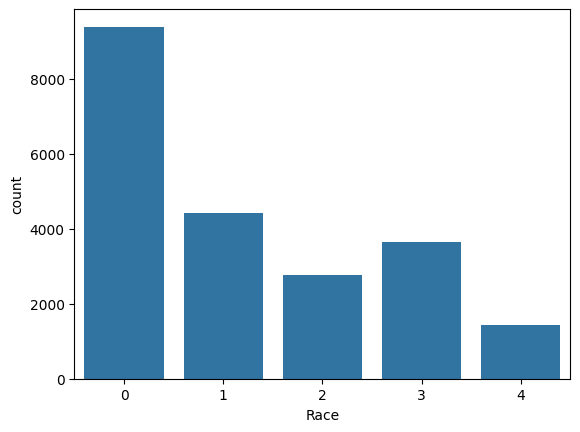

In [15]:
sns.countplot(df_cleaned, x="Race")

As we can see on previous plot, races are little bit disbalanced, so we need to solve this problem. In this notebook, we will use `class_weights` in order to balance classes. We will use it while fitting model

In [16]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=df_cleaned["Race"].unique(), y=df_cleaned["Race"])
class_weights_dict = {}
for i in range(len(df_cleaned["Race"].unique())):
    key = int(df_cleaned["Race"].unique()[i])
    value = class_weights[i]
    class_weights_dict[key] = value
    
class_weights_dict

{0: 0.461122351187307,
 1: 0.9799502149807648,
 2: 1.5718330308529946,
 3: 1.1870614035087719,
 4: 3.009312022237665}

Now when our dataset is cleaned and ready for larning, we can start defining model and training it.

### Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

df_cleaned.to_csv("cleaned_image_data.csv")

X_train, X_test, y_train, y_test = train_test_split(df_cleaned["Image"], df_cleaned.loc[:, ["Age", "Gender", "Race"]], test_size=0.2, random_state=52)
df_train = pd.concat([X_train, y_train], axis="columns")
df_test = pd.concat([X_test, y_test], axis="columns")

df_train.to_csv("train_dataset.csv")
df_test.to_csv("test_dataset.csv")

### Data Generators

After defining models, we need to write a generator for passing images to CNN. It is a good approach, because writing generator will free some RAM and make it possible to efficiently load big amount of photos to neural network

In [18]:
from keras.utils import load_img,  img_to_array
import os

def data_generator(directory, df_path, target_label, aug_count=8):
    df = pd.read_csv(df_path)
    image_paths = df['Image'].apply(lambda x: os.path.join(directory, x)).tolist()
    labels = df[target_label].astype(int)

    while 1:
        for index in range(df.shape[0]):
            path = image_paths[index]
            label = labels[index]
            image = load_img(path, target_size=(200, 200, 3))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = image / 255.0

            yield image, np.array([label])

In [19]:
directory = ""
train_labels_file = 'train_dataset.csv'
test_labels_file = "test_dataset.csv"

train_data_gen_age = data_generator(directory, train_labels_file, "Age")
test_data_gen_age = data_generator(directory, test_labels_file, "Age")

train_data_gen_race = data_generator(directory, train_labels_file, "Race")
test_data_gen_race = data_generator(directory, test_labels_file, "Race")

train_data_gen_gender = data_generator(directory, train_labels_file, "Gender")
test_data_gen_gender = data_generator(directory, test_labels_file, "Gender")

steps_train = pd.read_csv(train_labels_file).shape[0]
steps_test = pd.read_csv(test_labels_file).shape[0]

### Models Definitions and Training

I've decided to use `VGG16` without last layers as a base model and built my models on the top of it

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

backbone = VGG16(include_top=False, input_shape=(200, 200, 3))
backbone.trainable=False
import keras

def define_model_age_model_with_backbone():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))  # Output layer for regression (1 neuron, no activation)

    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])
    plot_model(model, show_shapes=True)
    
    return model

In [26]:
from pickle import dump
from keras.callbacks import ModelCheckpoint

modelcheckpoint = ModelCheckpoint("/kaggle/working/age_model_checkpoint_vgg16.keras", monitor="val_loss", verbose=1)

age_model = define_model_age_model_with_backbone()
history_age = age_model.fit(train_data_gen_age, steps_per_epoch=steps_train, validation_data=test_data_gen_age, validation_steps=steps_test, callbacks=[modelcheckpoint], epochs=50)

age_model.save("age_model_vgg16.h5")
print("Model Saved Succesfully")
dump(history_age.history, open("history_age_vgg16.pkl", "wb"))
print("History Saved Succesfully")

Epoch 1/50
17320/17321 [============================>.] - ETA: 0s - loss: 222.8154 - root_mean_squared_error: 14.9270
Epoch 1: saving model to /kaggle/working\age_model_checkpoint_vgg16.keras
17321/17321 [==============================] - 297s 16ms/step - loss: 222.8027 - root_mean_squared_error: 14.9266 - val_loss: 160.8683 - val_root_mean_squared_error: 12.6834
Epoch 2/50
17317/17321 [============================>.] - ETA: 0s - loss: 152.4884 - root_mean_squared_error: 12.3486
Epoch 2: saving model to /kaggle/working\age_model_checkpoint_vgg16.keras
17321/17321 [==============================] - 263s 15ms/step - loss: 152.4558 - root_mean_squared_error: 12.3473 - val_loss: 134.8029 - val_root_mean_squared_error: 11.6105
Epoch 3/50
17319/17321 [============================>.] - ETA: 0s - loss: 132.8330 - root_mean_squared_error: 11.5253
Epoch 3: saving model to /kaggle/working\age_model_checkpoint_vgg16.keras
17321/17321 [==============================] - 265s 15ms/step - loss: 132.81

In [43]:
from keras.layers import Flatten, Dense, Dropout, Input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

backbone = VGG16(include_top=False, input_shape=(200, 200, 3))
backbone.trainable=False

def define_model_gender_model_with_backbone():
  
	model = Sequential()
	model.add(Input(shape=(200, 200, 3)))
	model.add(Flatten())
	model.add(Dense(256, activation='relu'))
	model.add(Dropout(0.4))
	model.add(Dense(units=1, activation="sigmoid"))
	
	model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
	plot_model(model, show_shapes=True)
  
	return model

In [27]:
from pickle import dump
from keras.callbacks import ModelCheckpoint

modelcheckpoint = ModelCheckpoint("checkpoints/gender_model_checkpoint_vgg16.keras", monitor="val_loss")

gender_model = define_model_gender_model_with_backbone()

history_gender = gender_model.fit(train_data_gen_gender, steps_per_epoch=steps_train, validation_data=test_data_gen_gender, validation_steps=steps_test, callbacks=[modelcheckpoint], epochs=50)

gender_model.save("gender_model_vgg16.h5")
print("Model Saved Succesfully")
dump(history_gender.history, open("history_gender_vgg16.pkl", "wb"))
print("History Saved Succesfully")

Epoch 1/50
17321/17321 [==============================] - 195s 11ms/step - loss: 0.7464 - accuracy: 0.6773 - val_loss: 0.5395 - val_accuracy: 0.8257
Epoch 2/50
17321/17321 [==============================] - 166s 10ms/step - loss: 0.5516 - accuracy: 0.7537 - val_loss: 0.4935 - val_accuracy: 0.8185
Epoch 3/50
17321/17321 [==============================] - 168s 10ms/step - loss: 0.5173 - accuracy: 0.7711 - val_loss: 0.4439 - val_accuracy: 0.8532
Epoch 4/50
17321/17321 [==============================] - 164s 9ms/step - loss: 0.4953 - accuracy: 0.7853 - val_loss: 0.4235 - val_accuracy: 0.8485
Epoch 5/50
17321/17321 [==============================] - 166s 10ms/step - loss: 0.4864 - accuracy: 0.7928 - val_loss: 0.3959 - val_accuracy: 0.8709
Epoch 6/50
17321/17321 [==============================] - 166s 10ms/step - loss: 0.4809 - accuracy: 0.7923 - val_loss: 0.3920 - val_accuracy: 0.8707
Epoch 7/50
17321/17321 [==============================] - 169s 10ms/step - loss: 0.4775 - accuracy: 0.7944 

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

backbone = VGG16(include_top=False, input_shape=(200, 200, 3))
backbone.trainable=False

def define_model_race_model_with_backbone():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=5, activation="softmax"))

    model.compile(optimizer=Adam(learning_rate=0.000001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    plot_model(model, show_shapes=True)

    
    return model

In [28]:
from pickle import dump
from keras.callbacks import ModelCheckpoint

modelcheckpoint = ModelCheckpoint("checkpoints/race_model_checkpoint_vgg16_lr-e6.keras", monitor="val_loss")

race_model = define_model_race_model_with_backbone()

history_race = race_model.fit(train_data_gen_race, steps_per_epoch=steps_train, validation_data=test_data_gen_race,
                              validation_steps=steps_test, callbacks=[modelcheckpoint], epochs=50, class_weight=class_weights_dict)

race_model.save("race_model_vgg16_lr-e6.h5")
print("Model Saved Succesfully")
dump(history_race.history, open("history_race_vgg16_lr-e6.pkl", "wb"))
print("History Saved Succesfully")

Epoch 1/50
17321/17321 [==============================] - 288s 17ms/step - loss: 1.5217 - accuracy: 0.3559 - val_loss: 1.2468 - val_accuracy: 0.5615
Epoch 2/50
17321/17321 [==============================] - 293s 17ms/step - loss: 1.2657 - accuracy: 0.5235 - val_loss: 1.1267 - val_accuracy: 0.6010
Epoch 3/50
17321/17321 [==============================] - 295s 17ms/step - loss: 1.1631 - accuracy: 0.5728 - val_loss: 1.0525 - val_accuracy: 0.6308
Epoch 4/50
17321/17321 [==============================] - 300s 17ms/step - loss: 1.0963 - accuracy: 0.6050 - val_loss: 1.0216 - val_accuracy: 0.6382
Epoch 5/50
17321/17321 [==============================] - 300s 17ms/step - loss: 1.0402 - accuracy: 0.6247 - val_loss: 0.9701 - val_accuracy: 0.6574
Epoch 6/50
17321/17321 [==============================] - 301s 17ms/step - loss: 0.9977 - accuracy: 0.6448 - val_loss: 0.9507 - val_accuracy: 0.6650
Epoch 7/50
17321/17321 [==============================] - 301s 17ms/step - loss: 0.9662 - accuracy: 0.6570

### Test

In [21]:
from matplotlib.pyplot import imshow
from keras.models import load_model
from keras.utils import img_to_array, load_img
from keras import backend as K
import gc
import numpy as np
def parce_results(filepath):
    raw_image = load_img(filepath)
    imshow(raw_image)
    image = load_img(filepath, target_size=(200, 200, 3))
    
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = image / 255.0
    
    age_model = load_model("models/age_model_vgg16.h5")
    gender_model = load_model("models/gender_model_vgg16.h5")
    race_model = load_model("models/race_model_vgg16_lr-e6.h5")
    
    age = age_model.predict(image, verbose=0)
    gender = gender_model.predict(image, verbose=0)
    race = race_model.predict(image, verbose=0)
    
    max_index = np.argmax(race[0])
    
    if max_index == 0:
        race = "White"
    elif max_index == 1:
        race = "Black"
    elif max_index == 2:
        race = "Asian"
    elif max_index == 3:
        race = "Indian"
    else: race = "Other"
    
    gender_ans = None
    
    if gender[0][0] > 0.5:
        gender_ans = "Female"
    else : gender_ans = "Male"
        
    
  
    print(f"Age : {age[0][0]}")
    print(f"Gender : {gender_ans}")
    print(f"Race: {race}")
    
    del age_model
    del gender_model
    del race_model
    K.clear_session()
    gc.collect()
    
    

#### Kendick Lamar (36 y.o.)

Age : 37.00934982299805
Gender : Male
Race: Black


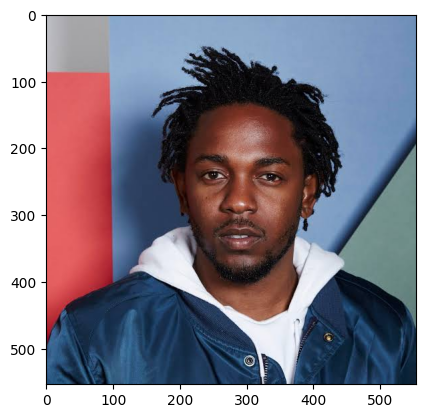

In [22]:
parce_results("test_images/kenrik_36.jpg")

#### Hideo Kodjima(40 y.o.)

Age : 18.819175720214844
Gender : Male
Race: White


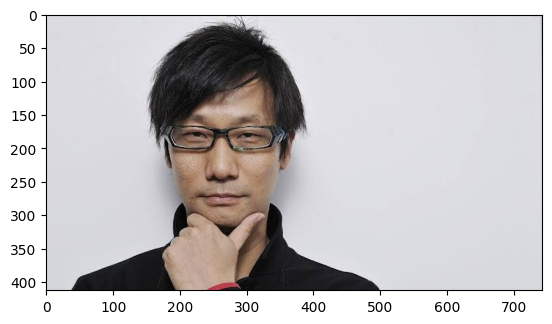

In [23]:
parce_results("test_images/hideo_40.jpg")

#### Jung Ho Yeon (29 y.o.)

Age : 32.329566955566406
Gender : Female
Race: White


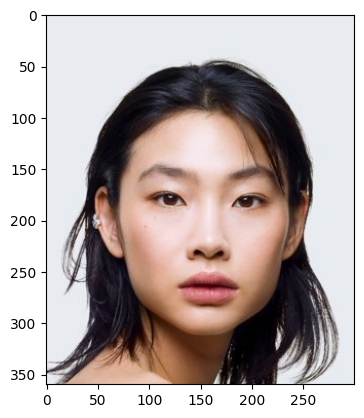

In [24]:
parce_results("test_images/jung_ho_yeon_29.jpg")

#### Jason Statham (55 y.o.)

Age : 40.30303955078125
Gender : Male
Race: White


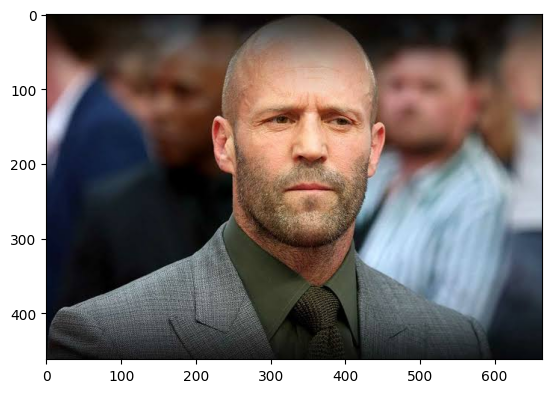

In [25]:
parce_results("test_images/jason_statham_55.jpg")

#### Swae Lee (25 y.o.)

Age : 41.01747512817383
Gender : Male
Race: Black


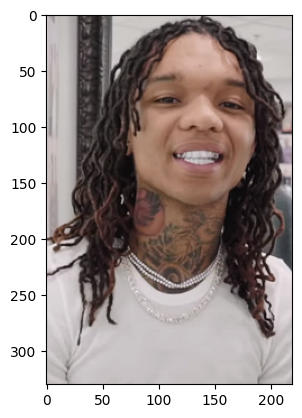

In [26]:
parce_results("test_images/swae_lee_25.png")

#### Priyanka Chopra (41 y.o.)

Age : 35.39659881591797
Gender : Female
Race: White


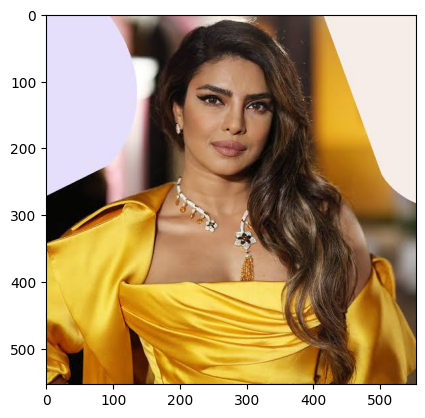

In [28]:
parce_results("test_images/priyanka_41.jpg")

#### Taylor Swift (34 y.o.)

Age : 15.548555374145508
Gender : Female
Race: White


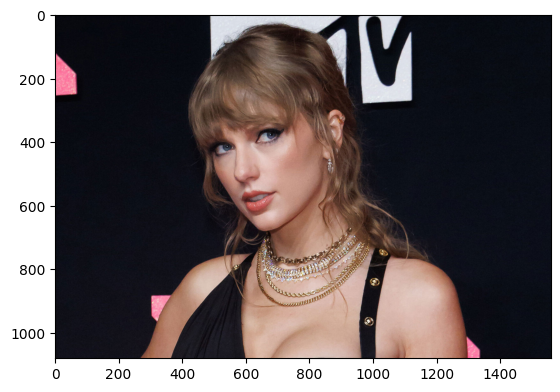

In [29]:
parce_results("test_images/taylor_34.jpg")

#### Maxim (19 y.o.)

Age : 40.34211730957031
Gender : Male
Race: White


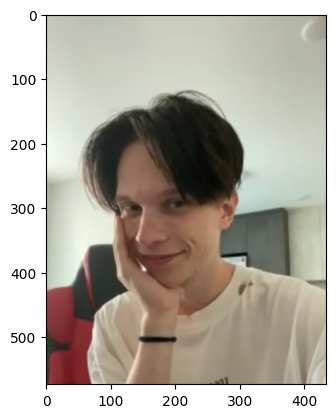

In [30]:
parce_results("test_images/maxim_19.png")

#### Jackie Chan (70 y.o.)

Age : 57.21550750732422
Gender : Male
Race: Black


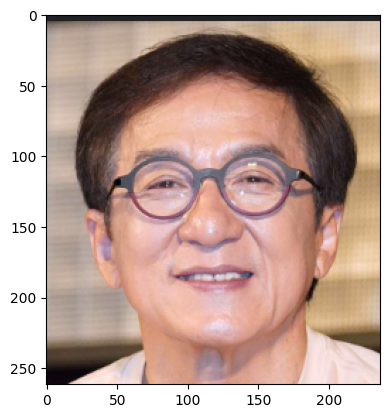

In [31]:
parce_results("test_images/jackie_chan_70.png")

### Summary 

As we can see in test images, age model and gender models are quite accurate. Age model gives good age prediction in most cases, gender model gave only one wrong prediction. Race model still not accurate enough. It is good in identifying white and black people, but it has some problem with other races. Probably, because of classes disbalance. This problem could be probably solved with the help of data augumentation or other technique, which was not implemented for this notebook.